# RCT overhead and GPU Utilization

This analysis is based on the data from here: https://github.com/radical-experiments/deepdriveMD/tree/master/data/raw/incite


Topics to discuss:
- RCT Overhead in stage transition
- GPU Utilization


## Data preparation

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
sid = 're.session.login4.hrlee.018463.0000'
session = ra.Session(sid, "radical.pilot")

## Stages from Units

In [ ]:
units = session.get(etype='unit')

In [ ]:
stages = {}
for unit in units:
    tid, tname, sid, sname, pid, pname = (unit.description['name'].split(','))
    try:
        stages[sid]['stime'] = min(stages[sid]['stime'], unit.timestamps(event={ru.EVENT:'cu_exec_start'})[0])
        stages[sid]['etime'] = max(stages[sid]['etime'], unit.timestamps(event={ru.EVENT:'cu_exec_stop'})[0])
    except:
        stages[sid] = { 
            'stime': unit.timestamps(event={ru.EVENT:'cu_exec_start'})[0],
            'etime': unit.timestamps(event={ru.EVENT:'cu_exec_stop'})[0] 
        }

In [14]:
stages

{'stage.0000': {'stime': 15923.404249668121, 'etime': 18058.40424966812},
 'stage.0001': {'stime': 18067.40424966812, 'etime': 18081.40424966812},
 'stage.0002': {'stime': 18090.40424966812, 'etime': 19266.40424966812},
 'stage.0003': {'stime': 19275.40424966812, 'etime': 21949.40424966812},
 'stage.0004': {'stime': 21957.40424966812, 'etime': 22404.40424966812},
 'stage.0005': {'stime': 22411.40424966812, 'etime': 23214.40424966812},
 'stage.0006': {'stime': 23227.40424966812, 'etime': 23652.40424966812},
 'stage.0007': {'stime': 23659.40424966812, 'etime': 24442.40424966812},
 'stage.0008': {'stime': 24454.40424966812, 'etime': 24929.40424966812},
 'stage.0009': {'stime': 24937.40424966812, 'etime': 25648.40424966812},
 'stage.0010': {'stime': 25658.40424966812, 'etime': 26086.40424966812},
 'stage.0011': {'stime': 26094.40424966812, 'etime': 26771.40424966812},
 'stage.0012': {'stime': 26783.40424966812, 'etime': 27206.40424966812},
 'stage.0013': {'stime': 27215.40424966812, 'etime

In [ ]:
stage_transition_ovh = []
prev_etime = 0
for stage_id, time_values in stages.items():
    stage_transition_ovh.append(time_values['stime'] - prev_etime)
    prev_etime = time_values['etime']

In [26]:
stage_transition_ovh[1:]

[9.0,
 9.0,
 9.0,
 8.0,
 7.0,
 13.0,
 7.0,
 12.0,
 8.0,
 10.0,
 8.0,
 12.0,
 9.0,
 11.0,
 8.0,
 16.0,
 14.0,
 14.0,
 9.0,
 16.0,
 9.0,
 14.0,
 12.0]

avg (s): 10.61


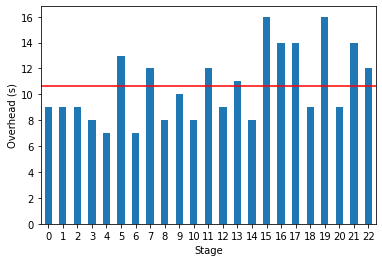

In [25]:
df_stage_ovh = pd.DataFrame(stage_transition_ovh[1:], columns=['ovh'])
ax= df_stage_ovh.plot.bar(rot=0, legend=False)
plt.axhline(y=np.mean(df_stage_ovh['ovh']), color='r', linestyle='-')
ax.set_ylabel('Overhead (s)')
ax.set_xlabel('Stage')
print ("avg (s): {:.4}".format(np.mean(df_stage_ovh['ovh'])))

## Overhead in Stage transition

The plot shows a cost between stages and the average overhead is about 10 second in this experiment which has the following configurations:

- 60 conncurrent simulations
- 10 iterations
  - OpenMM/Interence run every iteration
  - HDF5/CVAE training run in 1st and 5th

avg (s): 10.61


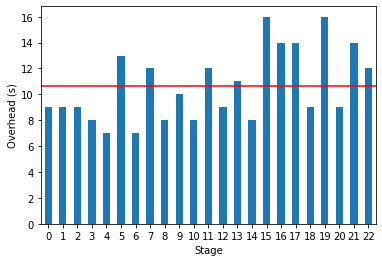

In [4]:
df_stage_ovh = pd.DataFrame(stage_ovh, columns=['ovh', 'curr','prev','transition'])
ax= df_stage_ovh.plot.bar(rot=0, legend=False)
plt.axhline(y=np.mean(df_stage_ovh['ovh']), color='r', linestyle='-')
ax.set_ylabel('Overhead (s)')
ax.set_xlabel('Stage')
print ("avg (s): {:.4}".format(np.mean(df_stage_ovh['ovh'])))

### Stage transition with annotation
The x-axis shows a stage with names of previous and current tasks (prev -> curr).

Text(0.5, 0, 'Stage transition')

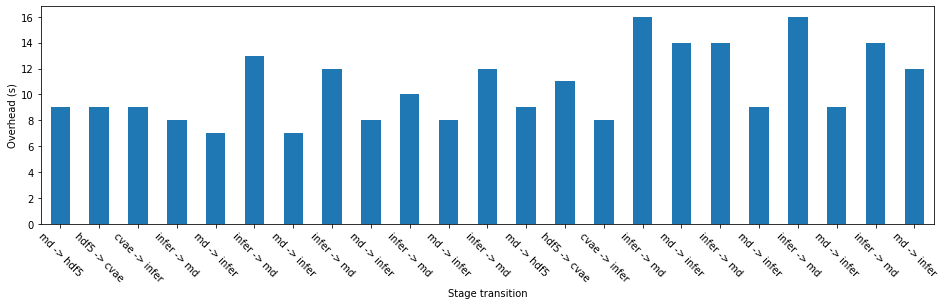

In [5]:
ax=df_stage_ovh.plot.bar(x='transition',y='ovh', rot=-45, legend=False,figsize=(16,4))
ax.set_ylabel('Overhead (s)')
ax.set_xlabel('Stage transition')

### Overheads (Startup, stage transition, shutdown)

In [6]:
# Pilot lifetime
# single pilot only
bootstrap_start = session.get(etype='pilot')[0].timestamps(event={ru.EVENT:'bootstrap_0_start'})
pilot_ended = session.get(etype="pilot")[0].timestamps(event= [{ru.STATE:rp.CANCELED},
                                                               {ru.STATE:rp.DONE},
                                                               {ru.STATE:rp.FAILED}])
pilot_duration = session.get(etype="pilot")[0].duration(event=[{1:"bootstrap_0_start"}, 
                                                               [{ru.STATE:rp.CANCELED},
                                                               {ru.STATE:rp.DONE},
                                                               {ru.STATE:rp.FAILED}]])


# Unit lifetime
units=session.filter(etype='unit'    , inplace=False)
unit_duration = units.duration(event=[{ru.EVENT: 'cu_exec_start', ru.STATE: None},
                      {ru.EVENT: 'cu_exec_stop' , ru.STATE: None} ])

first_unit_start = float('inf')
last_unit_end = 0
for unit in session.get(etype='unit'):
    u_start = unit.timestamps(event={ru.EVENT:'cu_exec_start'})
    u_end = unit.timestamps(event={ru.EVENT:'cu_exec_stop'})
    first_unit_start = min(first_unit_start, u_start)
    last_unit_end = max(last_unit_end, u_end)

ovh_s = [first_unit_start - bootstrap_start]
ovh_e = [pilot_ended - last_unit_end]
ovh_m = [sum(df_stage_ovh['ovh'])]
ovh_t = [pilot_duration - unit_duration]

,ovh_s (startup),ovh_e (shutdown),ovh_m (stage transition),ovh_t (total)
adrp,57.146576,34.30333,232.0,335.449906


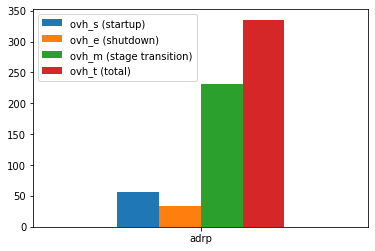

In [7]:
index = ['adrp']
df = pd.DataFrame({'ovh_s (startup)': ovh_s,
                   'ovh_e (shutdown)': ovh_e,
                   'ovh_m (stage transition)': ovh_m,
                  'ovh_t (total)': ovh_t}, index=index)
ax = df.plot.bar(rot=0)
df

### Walltime efficiency

In [8]:
print ("{:.4} %".format(100*(1-(ovh[0]/unit[0]))))

98.42 %


In [9]:
stime = float('inf')
for i in df_tmp:
    stime = min(stime, i[0])
for i in df_tmp:
    i[0] -= stime
    
#df_tmp

## GPU Utilization

The plot is prepared to show resource utilization and you expect to see maximum utilization when the plot is filled without empty space.

Please be aware that:
 - four colors are avialable to distinguish task types, i.e. MD/HDF5/CVAE/INFER
 - GPU is used between two dots:
    - small dots: start to use GPU for calculation
    - big dots: end to use GPU
    
In short, the plot shows
- GPU is IDLE after big dots
- GPU is ACTIVE from the small dots to the big dots

Text(0, 0.5, 'GPU Index')

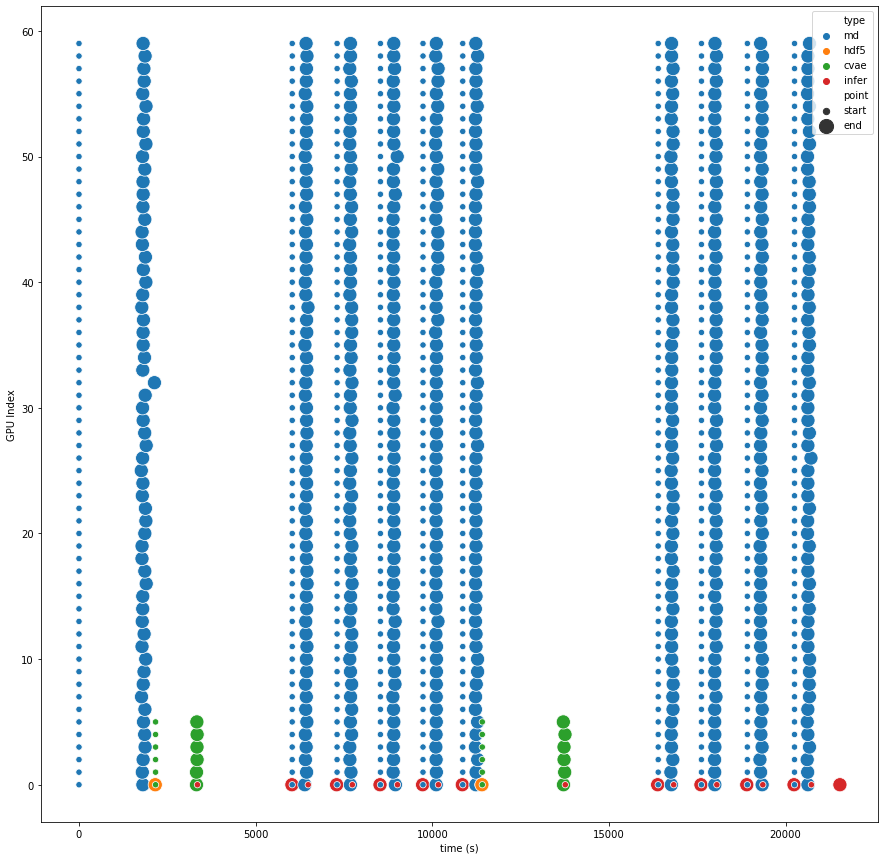

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
df = pd.DataFrame(df_tmp,
                  columns=['time', 'unit_id', 'gpu_idx','point','type'])
sns.scatterplot(x='time',y='gpu_idx',marker='o', hue='type', size='point',sizes=(200, 40), alpha=1,data=df)
ax.set_xlabel('time (s)')
ax.set_ylabel('GPU Index')

### GPU Utilization

In [11]:
tot=0
util=0
for r in res:
    tot += sum(res[r])
    if r == "md":
        util += sum(res[r])
    if r == "hdf5":
        util += sum(res[r])*1/60
    if r == "cvae":
        util += sum(res[r])*6/60
    if r == "infer":
        util += sum(res[r])*1/60

from pprint import pprint
print("GPU time fully utilized (sec): {:.6}\n".format(util),
       "Total Unit duration (sec): {}\n".format(tot),
       "GPU Walltime Utilization (%): {:.4}".format(100*util/tot))

GPU time fully utilized (sec): 6625.62
 Total Unit duration (sec): 21291
 GPU Walltime Utilization (%): 31.12
